Dans ce notebook, il s'agira de faire la partie modélisation du projet. Après un nettoyage de la base des critiques en utilisant des techniques de NLP, nous allons réliaser des modèles permettant de prédire la positivité ou négativité de la critique. Ensuite, nous comparerons les résultats obtenus à un modèle pré entrainé sur des textes en français, issue de BERT, qu'on aura au préalable fit sur nos données. Cette partie sera plutot lié au deep learning.

### Imports nécessaires

In [13]:
# Classique python
import pandas as pd
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from dateutil import parser 
import requests


In [8]:
# ML

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearnex import patch_sklearn

In [9]:
# CamemBERT
import torch
from transformers import CamembertForSequenceClassification, CamembertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

import torch.nn as nn
from torch.nn.parallel import DataParallel

from tqdm import tqdm
import time

### Machine Learning

In [11]:
df_critiques = pd.read_csv("df_critiques_modif.csv")

In [7]:
df_critiques_mod = df_critiques.sample(n=100000, random_state=11)  # Utilisez un random_state pour la reproductibilité

In [8]:
df_critiques_mod.groupby('Polarité_réelle').size()

Polarité_réelle
0    44800
1    55200
dtype: int64

On aurait pu mieux gerer la proportion (essayer d'avoir dun 50/50) pour des résultats plus fiables. Mais tel qu'il en ait, c'est acceptable.


In [10]:
# On prépare nos  jeux de test et d'entrainement pour le countvectorizer et pour le ML

critique_train, critique_test, polarite_train, polarite_test = train_test_split(df_critiques_mod['Critique_nettoye'], df_critiques_mod['Polarité_réelle'], test_size=0.3, random_state=4) 

In [65]:
# CountVectorizer 

cv = CountVectorizer()
cv_train_features = cv.fit_transform(critique_train)
cv_test_features = cv.transform(critique_test)

In [55]:
patch_sklearn()


# Rôle de la fonction : Fit et prédicitons
# Entrée : Modèle considéré, les deux jeux d'entrainement et le jeu des critiques-test 
# Sortie : predictions du modèle
def fitting_predictions(model, train_features, train_labels, test_features):
    model.fit(train_features, train_labels)
    predictions = model.predict(test_features)
    return predictions


# Rôle de la fonction : Renvoie les résultats du modèle
# Entrée : Jeu de test et prédictions
# Sortie : les résultats du modèles

def print_metrics(test_labels, predictions):
    # On stock nos données dans un dictionnaire
    results = {
        'Accuracy': metrics.accuracy_score(test_labels, predictions),
        'Precision': metrics.precision_score(test_labels, predictions),
        'Recall': metrics.recall_score(test_labels, predictions),
        'F1 Score': metrics.f1_score(test_labels, predictions),
        'Classification Report': metrics.classification_report(test_labels, predictions),
        'Confusion Matrix': metrics.confusion_matrix(test_labels, predictions)
    }
    
    # Print metriques
    print("\nAccuracy:", results['Accuracy'])
    print("Precision:", results['Precision'])
    print("Recall:", results['Recall'])
    print("F1 Score:", results['F1 Score'])
    
    # Print classification report
    print("\nClassification Report:")
    print(results['Classification Report'])

    # Display confusion matrix as a heatmap using seaborn
    cm = confusion_matrix(test_labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    return results


# Rôle de la fonction : Fit + résultat du modèle
# Entrée : modèle et les 4 jeux de données
# Sortie : les résultats du modèles
def evaluate_model_final(model, train_features, train_labels, test_features, test_labels):
    
    predictions = fitting_predictions(model, train_features, train_labels, test_features)

    # Cross-validation 
    cv_scores = cross_val_score(model, train_features, train_labels, cv=StratifiedKFold(n_splits=5), scoring='accuracy')
    print("Cross-validation Scores:", cv_scores)
    print("Mean CV Accuracy:", np.mean(cv_scores))

    print_metrics(test_labels, predictions)

    return 1

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


#### Résultats Text Blob

On va utiliser la fonction print_metrics() afin de regarder la fiabilité des prédictions faites avec textblob.


Accuracy: 0.6718426501035196
Precision: 0.6397220833890621
Recall: 0.9263309183852891
F1 Score: 0.7567998584284518

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.36      0.50    319525
           1       0.64      0.93      0.76    392417

    accuracy                           0.67    711942
   macro avg       0.72      0.64      0.63    711942
weighted avg       0.71      0.67      0.64    711942



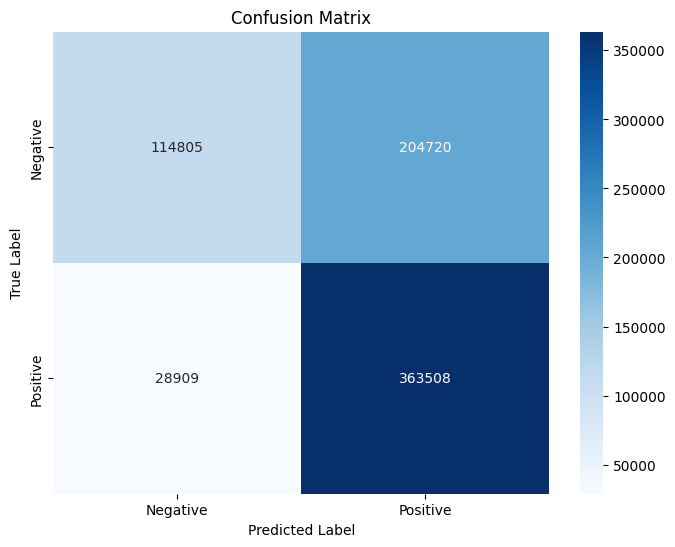

{'Accuracy': 0.6718426501035196,
 'Precision': 0.6397220833890621,
 'Recall': 0.9263309183852891,
 'F1 Score': 0.7567998584284518,
 'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.80      0.36      0.50    319525\n           1       0.64      0.93      0.76    392417\n\n    accuracy                           0.67    711942\n   macro avg       0.72      0.64      0.63    711942\nweighted avg       0.71      0.67      0.64    711942\n',
 'Confusion Matrix': array([[114805, 204720],
        [ 28909, 363508]])}

In [52]:
test_labels= df_critiques['Polarité_réelle']
predictions = df_critiques['Text_blob_critique_nettoyé']

print_metrics(test_labels, predictions)

Les performances du modèle de classification sont évaluées avec une précision globale de 67.18%. Le modèle présente une précision de 63.97%, indiquant sa capacité à correctement classifier les exemples positifs, tandis que le recall est élevé à 92.63%, indiquant la capacité du modèle à identifier la majorité des exemples positifs. Le F1 score, une mesure équilibrée entre précision et recall, est de 75.68%. En examinant la matrice de confusion, on observe que le modèle a bien performé sur les exemples négatifs (classe 0), mais a eu des difficultés avec les exemples positifs (classe 1), où il a eu plus de faux négatifs que de faux positifs.
L’idée ensuite et d’appliquer des modèles de ML en vue d’améliorer les résultats. 

### Modèles ML

Nous allons utiliser deux modèles : la regression logistique et le random forrest, qui sont assez pertienents dans notre cas d'étude pour leur interprétabilité



Cross-validation Scores: [0.82442857 0.82928571 0.82935714 0.82078571 0.82578571]
Mean CV Accuracy: 0.8259285714285716

Accuracy: 0.8263666666666667
Precision: 0.8284367909709698
Recall: 0.863030303030303
F1 Score: 0.8453797975600345

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.78      0.80     13500
           1       0.83      0.86      0.85     16500

    accuracy                           0.83     30000
   macro avg       0.83      0.82      0.82     30000
weighted avg       0.83      0.83      0.83     30000



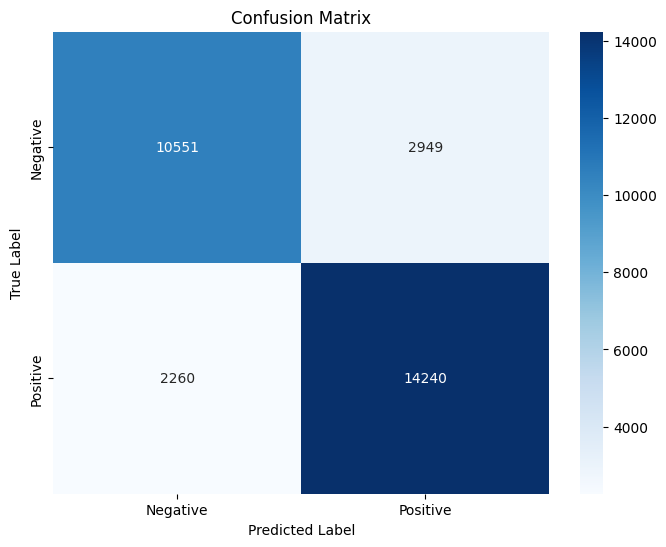

CPU times: user 21min 11s, sys: 1h 51min 36s, total: 2h 12min 48s
Wall time: 3min 21s


In [67]:
%%time
# Logistic Regression
model_lr = LogisticRegression(C=0.5, max_iter=100000)

# CPU times: user 27min 11s, sys: 2h 21min 46s, total: 2h 48min 58s
# Wall time: 4min 15s

In [ ]:
logistic_regression_results = evaluate_model_final(model_lr, cv_train_features, polarite_train, cv_test_features, polarite_test)


Les résultats de la validation croisée montrent une performance cohérente du modèle, avec des scores d'accuracy variant entre 82.07% et 82.94%, et une accuracy moyenne de 82.59%. Lors de l'évaluation sur un ensemble de test distinct, le modèle a obtenu une accuracy de 82.64%. La précision globale du modèle est de 82.84%, indiquant sa capacité à classifier correctement les exemples, avec une précision de 82.84%, un recall de 86.30%, et un F1 score de 84.54%. La matrice de confusion révèle que le modèle a une meilleure performance pour la classe 1.

Cross-validation Scores: [0.80971429 0.8125     0.81592857 0.80964286 0.80914286]
Mean CV Accuracy: 0.8113857142857143

Accuracy: 0.8113
Precision: 0.8126334006345544
Recall: 0.8537575757575757
F1 Score: 0.8326880449238953

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.76      0.78     13500
           1       0.81      0.85      0.83     16500

    accuracy                           0.81     30000
   macro avg       0.81      0.81      0.81     30000
weighted avg       0.81      0.81      0.81     30000



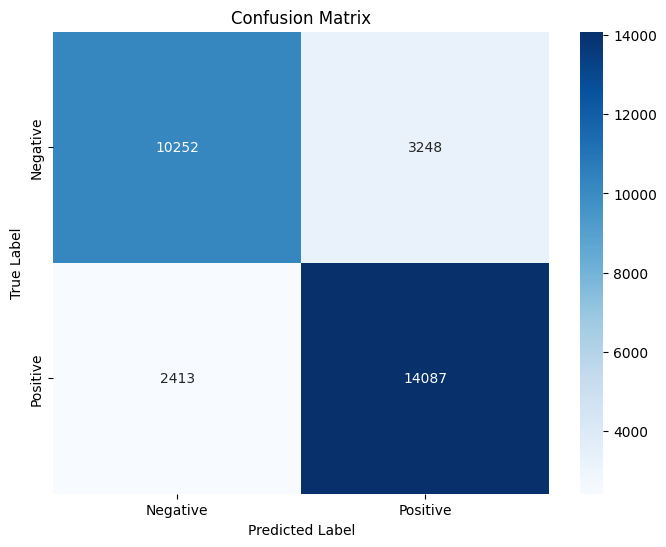

CPU times: user 29min 36s, sys: 0 ns, total: 29min 36s
Wall time: 29min 34s


In [68]:
%%time
# Example with Random Forest
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_results = evaluate_model_final(random_forest, cv_train_features, polarite_train, cv_test_features, polarite_test)

## CamemBERT

In [21]:
# Prétraiter les données
def preprocess_data(critique, polarite, tokenizer):
    encoded = tokenizer.batch_encode_plus(
        critique,
        add_special_tokens=False,
        padding=True,
        return_attention_mask=True,
        truncation=True,
        return_tensors='pt'
    )

    polarite_ = torch.tensor(polarite)

    return encoded['input_ids'], encoded['attention_mask'], polarite_


# Création du dataloader à partir de df et du tolenizer
def data_loader(df, tokenizer):
    critique = df['Critique'].values.tolist()
    polarite = df['Polarité_réelle'].values.tolist()

    input_ids_all, attention_mask_all, polarite_all = preprocess_data(critique, polarite, tokenizer)
    input_ids_all_, attention_mask_all_, polarite_all_ = input_ids_all.to('cuda'), attention_mask_all.to('cuda'), polarite_all.to('cuda')
    dataset = TensorDataset(input_ids_all_ , attention_mask_all_, polarite_all_)

    # Define data loaders
    batch_size=16
    loader = DataLoader(dataset, sampler=RandomSampler(dataset), batch_size=batch_size)
    return loader


# Evaluate du model sur le test set (puis dans une autre mesure sur notre base en général)
def modele_eval_bert(loader, model):
    model.to('cuda')
    loader
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to('cuda'), attention_mask.to('cuda'), labels.to('cuda')
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions.extend(logits.argmax(dim=1).tolist())
            true_labels.extend(labels.squeeze().tolist())
    return predictions, true_labels


In [ ]:
critique = df_critiques_mod['Critique'].values.tolist()
polarite = df_critiques_mod['Polarité_réelle'].values.tolist()

In [13]:
# Charger le modèle Camembert pré-entraîné et le tokenizer
model_name = "camembert-base"
tokenizer = CamembertTokenizer.from_pretrained(model_name)
model = CamembertForSequenceClassification.from_pretrained(model_name)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [147]:
# Séparer les données en ensembles d'entraînement et de test
critique_train, critique_test, polarite_train, polarite_test = train_test_split(critique, polarite, test_size=0.3, random_state=4)

In [ ]:
input_ids_train, attention_mask_train, polarite_train = preprocess_data(critique_train, polarite_train, tokenizer)
input_ids_test, attention_mask_test, polarite_test = preprocess_data(critique_test, polarite_test, tokenizer)

In [17]:
# Déplacez le modèle sur le GPU s'il est disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Assurez-vous que votre modèle est défini sur le CPU avant de le passer à DataParallel
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs.")
    model = nn.DataParallel(model)


# Déplacez les données d'entraînement sur le GPU
input_ids_train_, attention_mask_train_, polarite_train_ = input_ids_train.to(device), attention_mask_train.to(device), polarite_train.to(device)
train_dataset = TensorDataset(input_ids_train_, attention_mask_train_, polarite_train_)

# Déplacez les données de test sur le GPU
input_ids_test_, attention_mask_test_, polarite_test_ = input_ids_test.to(device), attention_mask_test.to(device), polarite_test.to(device)
test_dataset = TensorDataset(input_ids_test_ , attention_mask_test_, polarite_test_)

# Def des data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
test_loader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

# Def des hyperparamètres
epochs = 6
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)


Using 2 GPUs.


In [18]:
model.train()
for epoch in range(epochs):
    total_loss = 0.0
    num_batches = len(train_loader)

    # Initialize tqdm for progress bar
    progress_bar = tqdm(enumerate(train_loader), total=num_batches, desc=f'Epoch {epoch + 1}/{epochs}', unit='batch')

    for batch_idx, batch in progress_bar:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels.unsqueeze(1))
        loss = outputs.loss.mean()  # or any other reduction operation that returns a scalar
        loss.backward()
        optimizer.step()


        total_loss += loss.item()

        # Update tqdm bar with current loss
        progress_bar.set_postfix({'loss': loss.item(), 'avg_loss': total_loss / (batch_idx + 1)})

        # Optional: Simulate time delay to show the progress bar
        time.sleep(0.1)

    # Print epoch-level training statistics
    avg_epoch_loss = total_loss / num_batches
    print(f'Epoch [{epoch + 1}/{epochs}], Average Training Loss: {avg_epoch_loss:.4f}')



# Epoch 1/6: 100%|██████████| 4375/4375 [1:41:51<00:00,  1.40s/batch, loss=0.208, avg_loss=0.285] 
# Epoch [1/6], Average Training Loss: 0.2852
# Epoch 2/6: 100%|██████████| 4375/4375 [1:41:47<00:00,  1.40s/batch, loss=0.284, avg_loss=0.223]  
# Epoch [2/6], Average Training Loss: 0.2227
# Epoch 3/6: 100%|██████████| 4375/4375 [1:41:46<00:00,  1.40s/batch, loss=0.351, avg_loss=0.17]   
# Epoch [3/6], Average Training Loss: 0.1702
# Epoch 4/6: 100%|██████████| 4375/4375 [1:41:48<00:00,  1.40s/batch, loss=0.0962, avg_loss=0.121] 
# Epoch [4/6], Average Training Loss: 0.1207
# Epoch 5/6: 100%|██████████| 4375/4375 [1:41:47<00:00,  1.40s/batch, loss=0.0165, avg_loss=0.0868] 
# Epoch [5/6], Average Training Loss: 0.0868
# Epoch 6/6: 100%|██████████| 4375/4375 [1:41:46<00:00,  1.40s/batch, loss=0.00792, avg_loss=0.062] 
# Epoch [6/6], Average Training Loss: 0.0620


# Time : 610 46.8s (1Oh 10 min)

Epoch 1/6:   0%|          | 0/4375 [00:00<?, ?batch/s]2023-12-28 23:28:55.396237: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-28 23:28:55.469811: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-28 23:28:55.469857: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-28 23:28:55.471324: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-28 23:28:

Epoch [1/6], Average Training Loss: 0.2852


Epoch 2/6: 100%|██████████| 4375/4375 [1:41:47<00:00,  1.40s/batch, loss=0.284, avg_loss=0.223]  


Epoch [2/6], Average Training Loss: 0.2227


Epoch 3/6: 100%|██████████| 4375/4375 [1:41:46<00:00,  1.40s/batch, loss=0.351, avg_loss=0.17]   


Epoch [3/6], Average Training Loss: 0.1702


Epoch 4/6: 100%|██████████| 4375/4375 [1:41:48<00:00,  1.40s/batch, loss=0.0962, avg_loss=0.121] 


Epoch [4/6], Average Training Loss: 0.1207


Epoch 5/6: 100%|██████████| 4375/4375 [1:41:47<00:00,  1.40s/batch, loss=0.0165, avg_loss=0.0868] 


Epoch [5/6], Average Training Loss: 0.0868


Epoch 6/6: 100%|██████████| 4375/4375 [1:41:46<00:00,  1.40s/batch, loss=0.00792, avg_loss=0.062] 

Epoch [6/6], Average Training Loss: 0.0620


In [25]:
# On sauvegarde le modèle
torch.save(model.state_dict(), 'CamemBERT_critique_ac.pth')

D'après nos observations, le GPU a été trois fois plus rapide que le CPU.

In [19]:
%%time
# On évalue le modèle sur le test set
predictions, true_labels = modele_eval_bert(test_loader, model)


# Time 8m 45.3s

CPU times: user 13min 32s, sys: 4.92 s, total: 13min 37s
Wall time: 13min 11s



Accuracy: 0.8814666666666666
Precision: 0.8755367297203203
Recall: 0.9144848484848485
F1 Score: 0.8945870634967688

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.84      0.86     13500
           1       0.88      0.91      0.89     16500

    accuracy                           0.88     30000
   macro avg       0.88      0.88      0.88     30000
weighted avg       0.88      0.88      0.88     30000



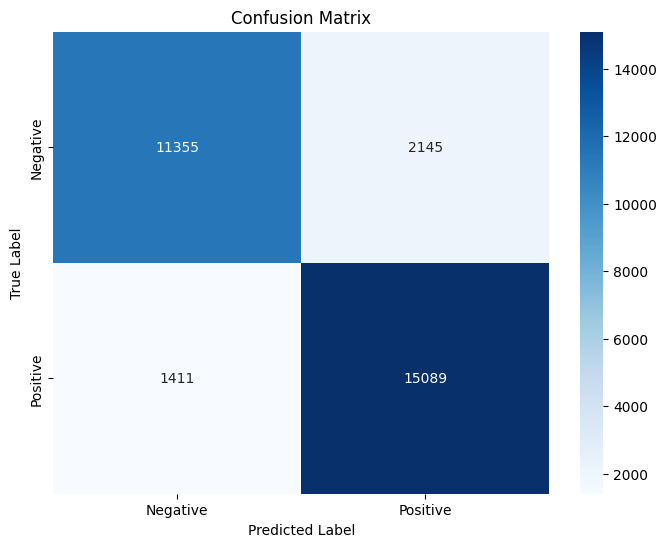

{'Accuracy': 0.8814666666666666,
 'Precision': 0.8755367297203203,
 'Recall': 0.9144848484848485,
 'F1 Score': 0.8945870634967688,
 'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.89      0.84      0.86     13500\n           1       0.88      0.91      0.89     16500\n\n    accuracy                           0.88     30000\n   macro avg       0.88      0.88      0.88     30000\nweighted avg       0.88      0.88      0.88     30000\n',
 'Confusion Matrix': array([[11355,  2145],
        [ 1411, 15089]])}

In [22]:
print_metrics(true_labels, predictions)

Les résultats indiquent que le modèle de classification a une performance globalement élevée, avec une accuracy de 88.15%, une précision de 87.55%, un recall de 91.45% et un F1 score de 89.46%. Ces scores suggèrent que le modèle a réussi à bien classifier les exemples positifs et négatifs dans l'ensemble de test. En examinant le rapport de classification, on constate que la précision, le rappel et le score F1 sont tous élevés pour les deux classes (0 et 1). 

### Analyse des performance des modèles

Le modèle basé sur TextBlob présente la performance la plus modeste parmi les quatre, avec une accuracy de 67.18%. En revanche, les modèles de Régression Logistique et Random Forest affichent des performances similaires, avec des accuracies respectives de 82.64% et 81.13%. Le modèle Camembert (Bert-based) se distingue nettement en démontrant une performance significativement supérieure, atteignant une accuracy de 88.15%, ainsi que des scores de précision, rappel et F1 supérieurs.

Ces résultats confirment les attentes générales selon lesquelles les modèles de machine learning traditionnels, tels que la Régression Logistique et Random Forest, présentent des performances intermédiaires. En revanche, le modèle Camembert, basé sur du deep, montre une meilleure précision pour les tâches de classification.

Cependant, il est important de noter que les modèles de machine learning traditionnels auraient pu bénéficier d'une amélioration  en se concentrant davantage sur l'optimisation des hyperparamètres. La décision de ne pas le faire était motivée par des contraintes temporelles, car cette approche aurait demandé un temps d'exécution significatif.

De plus, le modèle Camembert aurait pu être amélioré en ajustant finement des paramètres tels que le nombre de données d'entraînement, le nombre de batch (initialement nous avons voulu mettre 32 afin d’accélérer le modèle, mais on rencontrait une erreur lié à la mémoire), et le nombre d'époques. Si ce dernier paramètre avait pu être ajusté à 20 par exemple, on aurait certainement eu de meilleurs résultats. Mais sachant qu’une époque prenait 1h40 environ à s’exécuter, on en aurait eu pour plus de 33h d’entrainement. Ainsi, des contraintes de ressources matérielles ont limité ces ajustements. Par ailleurs, une gestion plus efficace de la parallélisation des calculs et l'accès à des ressources plus puissantes auraient potentiellement conduit à de meilleurs résultats.

En ce qui concerne la labelisation des données, une amélioration aurait pu être réalisée en adoptant une approche plus nuancée. Par exemple, l'utilisation de critères plus fins, tels que considérer les notes supérieures ou égales à 4 comme des critiques positives, celles inférieures à 2 comme négatives, et éventuellement introduire un label neutre pour les critiques intermédiaires, aurait pu renforcer la qualité des données d'entraînement et, par conséquent, améliorer la performance globale du modèle.

### Application du modèle CamemBERT à un film

In [14]:
# Lien Dropbox pour télécharger le modèle
drpbx_lk_model = 'https://www.dropbox.com/scl/fi/y5ytnm1zisoko4wlghk6c/CamemBERT_critique_ac.pth?rlkey=ku711ekbmevjysjw8kgunrz1n&dl=1'
model_name = "camembert-base"

# Télécharger le modèle depuis Dropbox
response = requests.get(drpbx_lk_model)
with open('CamemBERT_critique_ac.pth', 'wb') as file:
    file.write(response.content)

# Charger le tokenizer et le modèle
tokenizer = CamembertTokenizer.from_pretrained(model_name)
model1 = CamembertForSequenceClassification.from_pretrained(model_name)
model11 = torch.nn.DataParallel(model1)
model11.load_state_dict(torch.load('CamemBERT_critique_ac.pth'))


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

Notre prochaine étape consiste à appliquer notre modèle à un échantillon de 500 films, en collectant et analysant les commentaires associés. Pour chaque film, nous allons calculer le ratio entre le nombre de critiques positives et le nombre de critiques négatives. Cette métrique simple nous permettra de déterminer si le film est considéré comme un succès ou un échec.

La démarche sera la suivante : si le ratio est supérieur à 2, nous classerons le film comme un succès; sinon, il sera considéré comme un échec. Cette approche offre une évaluation quantitative basée sur la polarité des commentaires, nous permettant ainsi de catégoriser les films en fonction de la perception générale des spectateurs.

Parallèlement, nous avons également étiqueté notre échantillon en utilisant la note attribuée au film. Si la note est supérieure à 3, le film est qualifié de succès; sinon, il est considéré comme un échec.

Cette méthodologie combinée offre une double perspective, en comparant la classification basée sur l'analyse des sentiments avec celle basée sur les notations explicites. Cela nous permettra d'évaluer la cohérence de notre modèle avec les évaluations traditionnelles des films.

In [13]:
df_merged = pd.read_csv("df_merged.csv")

In [51]:
nb_film = 500
df_test_films = df_merged.sample(n=nb_film, random_state=1)

In [62]:
# Rôle : renvoie un dataframe avec les informations importantes
# Entrée : un dataframe contenant les films dont on veux prédire le succès ou l'échec
# Sortie : un dataframe 

def apply_model(df, model):
    # Créer des listes pour stocker les valeurs calculées
    accuracy_txt_blob_list = []
    accuracy_bert_list = []
    succes_reel_list = []
    succes_pred_list = []
    ratio_pc_nc_list = []

    df = df.loc[:, ["Titre original", "id allocine", "Notes spectateur"]]

    total_rows = len(df)
    progress_counter = 0

    for index, row in df.iterrows():
        try:
            progress_counter += 1
            print(f"Processing row {progress_counter} of {total_rows}")

            id_ac = row['id allocine']
            df_critiques_id = df_critiques[df_critiques['id_allocine'] == id_ac]

            # Gestion des erreurs pour accuracy_txt_blob
            try:
                accuracy_txt_blob = metrics.accuracy_score(df_critiques_id['Polarité_réelle'], df_critiques_id['Text_blob_critique_nettoyé'])
            except Exception as e:
                print(f"Erreur lors du calcul de accuracy_txt_blob pour la ligne {index}: {e}")
                accuracy_txt_blob = None

            # Gestion des erreurs pour modele_eval_bert
            try:
                loader = data_loader(df_critiques_id, tokenizer)
                all_predictions, true_labels = modele_eval_bert(loader, model)
                accuracy_bert = metrics.accuracy_score(true_labels, all_predictions)

                nombre_de_1 = all_predictions.count(1)
                nombre_de_0 = all_predictions.count(0)
                ratio_pc_nc = nombre_de_1 / nombre_de_0 if nombre_de_0 != 0 else None
            except Exception as e:
                print(f"Erreur lors du calcul de accuracy_bert pour la ligne {index}: {e}")
                accuracy_bert = None
                ratio_pc_nc = None

            # Succès réel du film (1 c'est un hit, 0 c'est un flop)
            succes_reel = 1 if row["Notes spectateur"] > 3 else 0

            # Succès prédit du film (1 c'est un hit, 0 c'est un flop).
            succes_pred = 1 if ratio_pc_nc is not None and ratio_pc_nc > 1.5 else 0

            # Ajouter les valeurs à la liste
            accuracy_txt_blob_list.append(accuracy_txt_blob)
            accuracy_bert_list.append(accuracy_bert)
            succes_reel_list.append(succes_reel)
            succes_pred_list.append(succes_pred)
            ratio_pc_nc_list.append(ratio_pc_nc)

        except Exception as e:
            print(f"Erreur lors du traitement de la ligne {index}: {e}")

    # Ajouter les listes comme nouvelles colonnes au DataFrame
    df["accuracy_txt_blob"] = accuracy_txt_blob_list
    df["accuracy_bert"] = accuracy_bert_list
    df["ratio_pc_nc"] = ratio_pc_nc_list
    df["succes_reel"] = succes_reel_list
    df["succes_pred"] = succes_pred_list
    
    return df


In [63]:
df = apply_model(df_test_films, model11)

Processing row 1 of 500
Processing row 2 of 500
Processing row 3 of 500
Processing row 4 of 500
Processing row 5 of 500
Processing row 6 of 500
Processing row 7 of 500
Processing row 8 of 500
Processing row 9 of 500
Processing row 10 of 500
Processing row 11 of 500
Processing row 12 of 500
Processing row 13 of 500
Processing row 14 of 500
Processing row 15 of 500
Erreur lors du calcul de accuracy_bert pour la ligne 331: 'int' object is not iterable
Processing row 16 of 500
Processing row 17 of 500
Processing row 18 of 500
Processing row 19 of 500
Processing row 20 of 500
Processing row 21 of 500
Processing row 22 of 500
Processing row 23 of 500
Processing row 24 of 500
Processing row 25 of 500
Processing row 26 of 500
Processing row 27 of 500
Processing row 28 of 500
Processing row 29 of 500
Processing row 30 of 500
Processing row 31 of 500
Processing row 32 of 500
Processing row 33 of 500
Processing row 34 of 500
Processing row 35 of 500
Processing row 36 of 500
Processing row 37 of 5


Accuracy: 0.788
Precision: 0.8811881188118812
Recall: 0.48633879781420764
F1 Score: 0.6267605633802816

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.96      0.85       317
           1       0.88      0.49      0.63       183

    accuracy                           0.79       500
   macro avg       0.82      0.72      0.74       500
weighted avg       0.81      0.79      0.77       500



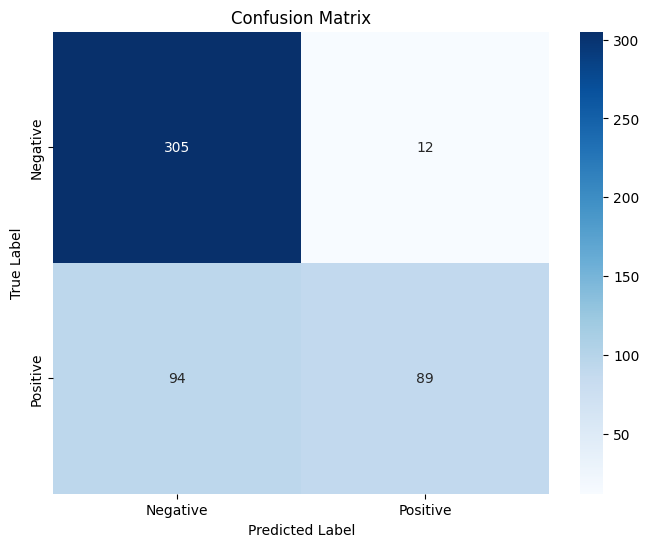

{'Accuracy': 0.788,
 'Precision': 0.8811881188118812,
 'Recall': 0.48633879781420764,
 'F1 Score': 0.6267605633802816,
 'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.76      0.96      0.85       317\n           1       0.88      0.49      0.63       183\n\n    accuracy                           0.79       500\n   macro avg       0.82      0.72      0.74       500\nweighted avg       0.81      0.79      0.77       500\n',
 'Confusion Matrix': array([[305,  12],
        [ 94,  89]])}

In [64]:
print_metrics(df["succes_reel"], df["succes_pred"])

# Conclusion du projet

Le projet visait à classifier des films en succès ou échec à partir de l'analyse de sentiments des critiques a produit des résultats encourageants. Les différentes étapes, de l'analyse de sentiments avec TextBlob à l'utilisation de modèles tels que la régression logistique, le Random Forest, et enfin le modèle Camembert, ont permis d'obtenir une précision globale de 78.8%. Cela suggère une performance significative dans la prédiction du succès ou de l'échec des films à partir des critiques.


Principales observations :

- Performance du modèle : Le modèle Camembert a démontré une performance supérieure par rapport aux autres modèles testés. Cela met en évidence la pertinence d'utiliser des modèles de traitement du langage naturel (NLP) plus avancés pour des tâches complexes comme la classification de films basée sur des données textuelles.

- Sources de données : L'utilisation du scraping sur Allociné et l'API de TMDb a fourni une source de données assez correctes. 




Limitations du projet :

- Biais dans les données : Les données provenant de sources en ligne peuvent être biaisées en fonction de la démographie des utilisateurs de ces plateformes par exemple...

- Complexité du jugement de succès/echec : La définition du succès ou de l'échec d'un film peut être subjective et dépendre de divers facteurs tels que le genre du film, le public cible, etc. Cette complexité peut rendre la tâche de classification plus délicate.




Possibilités d'amélioration :

- Enrichissement des données : L'ajout de données supplémentaires, telles que des informations sur les acteurs, les réalisateurs, ou des métriques financières, pourrait améliorer la qualité des prédictions.

- Fine-Tuning des modèles : Une optimisation des hyperparamètres des modèles ou l'exploration d'autres modèles pourrait conduire à des améliorations significatives de la performance.

- Élargissement des sources de critiques : L'inclusion de critiques provenant de différentes plateformes et sources pourrait améliorer la généralisation du modèle à un public plus large.

- Analyse des erreurs : Une analyse approfondie des erreurs de classification peut révéler des tendances spécifiques et guider des ajustements futurs du modèle.



Ce projet nous a permis de découvrir l'analyse de sentiments en l'appliquant à un cas concret, explorant des méthodes variées allant de modèles traditionnels comme la Régression Logistique à des architectures de deep learning telles que Camembert. La gestion des données, du web scraping à la préparation pour l'entraînement des modèles, a affiné nos compétences en prétraitement des données
Au-delà de l'acquisition de nouvelles connaissances et compétences, ce projet a été une véritable opportunité pour renforcer des aptitudes essentielles telles que le traitement des données, tout en cultivant des compétences transversales telles que l'adaptabilité, la pensée critique et la résolution de problèmes. 

